## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torchvision.models.resnet import BasicBlock, resnet18, Bottleneck
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import wandb

In [2]:
BATCH_SIZE = 128
LR = 1e-3
MIN_LR = 1e-5
NUM_WORKERS = 8
EPOCHS = 60
NAME = "exp002"

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.CIFAR10(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([        
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(dtype=torch.uint8),
        transforms.RandomApply(
            p=0.4,
            transforms=[
                transforms.RandomRotation(degrees=45),
            ]
        ),
        transforms.RandomPosterize(bits=6, p=0.15),
        transforms.RandomPerspective(p=0.3),        
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.ConvertImageDtype(dtype=torch.float32),
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),        
    ])
)
# 検証用データセット
val_datasets = datasets.CIFAR10(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([        
        transforms.Resize(128),        
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),
    ])
)

Files already downloaded and verified
Files already downloaded and verified


## 3. Modelの用意

In [4]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)             
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(
                64,
                64,
            ),
            BasicBlock(
                64,
                64,
            ),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(
                64,
                128,
                downsample=nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(128),
                ),
                stride=2,
            ),
            BasicBlock(
                128,
                128,
            ),
        )
        self.layer3 = nn.Sequential(            
            BasicBlock(
                128,
                256,
                downsample=nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(256),
                ),
                stride=2,
            ),
            BasicBlock(
                256,
                256,                
            ),
        )      
        self.layer4 = nn.Sequential(            
            BasicBlock(
                256,
                512,
                downsample=nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(512),
                ),
                stride=2
            ),
            Bottleneck(
                512,
                512,
                downsample=nn.Sequential(
                    nn.Conv2d(512, 2048, kernel_size=1, bias=False),
                    nn.BatchNorm2d(2048),
                ),
            ),
        )
        self.fc = nn.Sequential(
            nn.Linear(
                2048,            
                256,
            ),
            nn.Linear( 
                256,
                10,
            ),
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.pooling1(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
Cyfar10の入力画像は32×32pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [5]:
input_image, input_label = val_datasets[40]
input_image.shape

torch.Size([3, 128, 128])

In [6]:
input_label = torch.tensor([input_label])

In [7]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.4550, -2.4373, -2.1807, -2.1125, -2.2622, -2.2611, -1.9039, -2.5276,
         -2.4853, -2.6260]], grad_fn=<LogSoftmaxBackward0>)

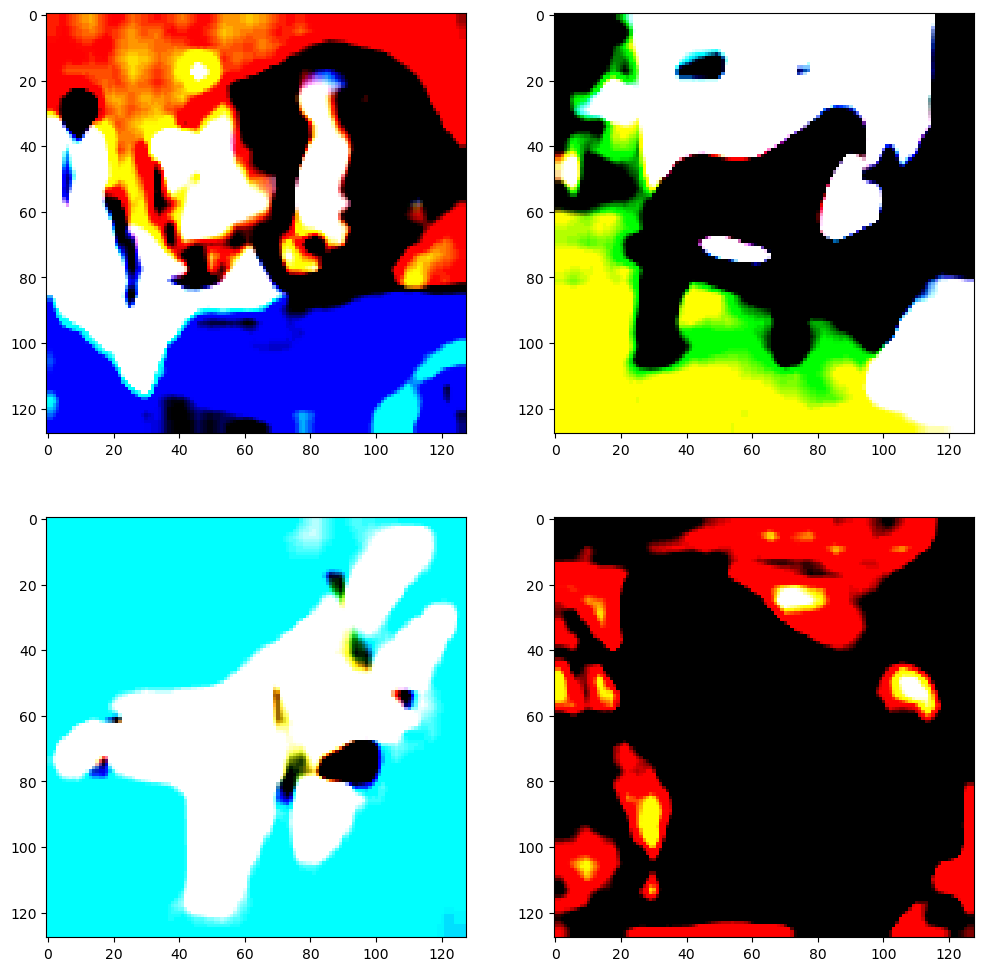

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(val_datasets[10 * (i + j * 2)][0].permute(1, 2, 0).numpy().clip(0, 1))

## 4.学習 & 検証

### 学習に必要な要素の準備

In [9]:
### wandbの設定
wandb.init(
    project="csg-training",    
    name="cyfar10",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fummicc1. Use `wandb login --relogin` to force relogin


In [10]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.AdamW(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=MIN_LR,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [11]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [12]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.autocast(device_type="cuda"):
            outs = model(imgs)
            loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    epoch_loss = epoch_loss / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.5f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc            
    wandb.log(results[epoch])

  0%|          | 0/60 [00:00<?, ?it/s]

epoch: 0, train loss: 0.01422. train acc: 0.315


  2%|▏         | 1/60 [00:43<42:34, 43.30s/it]

epoch: 0, val acc: 0.442


epoch: 1, train loss: 0.01183. train acc: 0.445


  3%|▎         | 2/60 [01:17<36:32, 37.80s/it]

epoch: 1, val acc: 0.489


epoch: 2, train loss: 0.01063. train acc: 0.504


  5%|▌         | 3/60 [01:50<34:06, 35.91s/it]

epoch: 2, val acc: 0.519


epoch: 3, train loss: 0.00966. train acc: 0.555


  7%|▋         | 4/60 [02:24<32:41, 35.03s/it]

epoch: 3, val acc: 0.596


epoch: 4, train loss: 0.00876. train acc: 0.600


  8%|▊         | 5/60 [02:58<31:35, 34.47s/it]

epoch: 4, val acc: 0.649


epoch: 5, train loss: 0.00815. train acc: 0.627


 10%|█         | 6/60 [03:31<30:41, 34.11s/it]

epoch: 5, val acc: 0.700


epoch: 6, train loss: 0.00764. train acc: 0.654


 12%|█▏        | 7/60 [04:05<29:58, 33.94s/it]

epoch: 6, val acc: 0.708


epoch: 7, train loss: 0.00717. train acc: 0.677


 13%|█▎        | 8/60 [04:38<29:17, 33.80s/it]

epoch: 7, val acc: 0.735


epoch: 8, train loss: 0.00670. train acc: 0.698


 15%|█▌        | 9/60 [05:12<28:39, 33.71s/it]

epoch: 8, val acc: 0.760


epoch: 9, train loss: 0.00636. train acc: 0.713


 17%|█▋        | 10/60 [05:46<28:09, 33.78s/it]

epoch: 9, val acc: 0.745


epoch: 10, train loss: 0.00600. train acc: 0.729


 18%|█▊        | 11/60 [06:19<27:30, 33.69s/it]

epoch: 10, val acc: 0.786


epoch: 11, train loss: 0.00571. train acc: 0.744


 20%|██        | 12/60 [06:53<26:57, 33.69s/it]

epoch: 11, val acc: 0.787


epoch: 12, train loss: 0.00542. train acc: 0.758


 22%|██▏       | 13/60 [07:26<26:21, 33.64s/it]

epoch: 12, val acc: 0.807


epoch: 13, train loss: 0.00517. train acc: 0.768


 23%|██▎       | 14/60 [08:00<25:44, 33.58s/it]

epoch: 13, val acc: 0.807


epoch: 14, train loss: 0.00498. train acc: 0.777


 25%|██▌       | 15/60 [08:33<25:09, 33.55s/it]

epoch: 14, val acc: 0.812


epoch: 15, train loss: 0.00479. train acc: 0.786


 27%|██▋       | 16/60 [09:07<24:35, 33.55s/it]

epoch: 15, val acc: 0.824


epoch: 16, train loss: 0.00456. train acc: 0.796


 28%|██▊       | 17/60 [09:40<24:02, 33.55s/it]

epoch: 16, val acc: 0.818


epoch: 17, train loss: 0.00440. train acc: 0.803


 30%|███       | 18/60 [10:14<23:29, 33.56s/it]

epoch: 17, val acc: 0.839


epoch: 18, train loss: 0.00422. train acc: 0.810


 32%|███▏      | 19/60 [10:47<22:54, 33.52s/it]

epoch: 18, val acc: 0.849


epoch: 19, train loss: 0.00409. train acc: 0.817


 33%|███▎      | 20/60 [11:21<22:20, 33.52s/it]

epoch: 19, val acc: 0.842


epoch: 20, train loss: 0.00393. train acc: 0.825


 35%|███▌      | 21/60 [11:54<21:49, 33.58s/it]

epoch: 20, val acc: 0.860


epoch: 21, train loss: 0.00376. train acc: 0.832


 37%|███▋      | 22/60 [12:29<21:21, 33.73s/it]

epoch: 21, val acc: 0.850


epoch: 22, train loss: 0.00365. train acc: 0.837


 38%|███▊      | 23/60 [13:02<20:43, 33.61s/it]

epoch: 22, val acc: 0.846


epoch: 23, train loss: 0.00352. train acc: 0.842


 40%|████      | 24/60 [13:35<20:09, 33.59s/it]

epoch: 23, val acc: 0.871


epoch: 24, train loss: 0.00339. train acc: 0.849


 42%|████▏     | 25/60 [14:09<19:36, 33.62s/it]

epoch: 24, val acc: 0.865


epoch: 25, train loss: 0.00325. train acc: 0.853


 43%|████▎     | 26/60 [14:43<19:04, 33.65s/it]

epoch: 25, val acc: 0.863


epoch: 26, train loss: 0.00309. train acc: 0.861


 45%|████▌     | 27/60 [15:16<18:27, 33.56s/it]

epoch: 26, val acc: 0.865


epoch: 27, train loss: 0.00301. train acc: 0.866


 47%|████▋     | 28/60 [15:50<17:54, 33.59s/it]

epoch: 27, val acc: 0.880


epoch: 28, train loss: 0.00293. train acc: 0.870


 48%|████▊     | 29/60 [16:23<17:18, 33.50s/it]

epoch: 28, val acc: 0.869


epoch: 29, train loss: 0.00280. train acc: 0.875


 50%|█████     | 30/60 [16:57<16:47, 33.59s/it]

epoch: 29, val acc: 0.882


epoch: 30, train loss: 0.00272. train acc: 0.879


 52%|█████▏    | 31/60 [17:31<16:16, 33.68s/it]

epoch: 30, val acc: 0.884


epoch: 31, train loss: 0.00262. train acc: 0.882


 53%|█████▎    | 32/60 [18:05<15:42, 33.67s/it]

epoch: 31, val acc: 0.889


epoch: 32, train loss: 0.00252. train acc: 0.887


 55%|█████▌    | 33/60 [18:38<15:09, 33.69s/it]

epoch: 32, val acc: 0.882


epoch: 33, train loss: 0.00245. train acc: 0.890


 57%|█████▋    | 34/60 [19:12<14:34, 33.65s/it]

epoch: 33, val acc: 0.883


epoch: 34, train loss: 0.00231. train acc: 0.898


 58%|█████▊    | 35/60 [19:45<13:58, 33.53s/it]

epoch: 34, val acc: 0.885


epoch: 35, train loss: 0.00225. train acc: 0.899


 60%|██████    | 36/60 [20:19<13:25, 33.58s/it]

epoch: 35, val acc: 0.878


epoch: 36, train loss: 0.00217. train acc: 0.902


 62%|██████▏   | 37/60 [20:52<12:52, 33.58s/it]

epoch: 36, val acc: 0.889


epoch: 37, train loss: 0.00208. train acc: 0.907


 63%|██████▎   | 38/60 [21:26<12:16, 33.47s/it]

epoch: 37, val acc: 0.892


epoch: 38, train loss: 0.00203. train acc: 0.909


 65%|██████▌   | 39/60 [21:59<11:44, 33.55s/it]

epoch: 38, val acc: 0.897


epoch: 39, train loss: 0.00197. train acc: 0.914


 67%|██████▋   | 40/60 [22:33<11:12, 33.61s/it]

epoch: 39, val acc: 0.893


epoch: 40, train loss: 0.00187. train acc: 0.916


 68%|██████▊   | 41/60 [23:06<10:36, 33.53s/it]

epoch: 40, val acc: 0.898


epoch: 41, train loss: 0.00185. train acc: 0.918


 70%|███████   | 42/60 [23:40<10:02, 33.49s/it]

epoch: 41, val acc: 0.898


epoch: 42, train loss: 0.00180. train acc: 0.919


 72%|███████▏  | 43/60 [24:14<09:31, 33.59s/it]

epoch: 42, val acc: 0.900


epoch: 43, train loss: 0.00175. train acc: 0.923


 73%|███████▎  | 44/60 [24:47<08:56, 33.56s/it]

epoch: 43, val acc: 0.899


epoch: 44, train loss: 0.00166. train acc: 0.927


 75%|███████▌  | 45/60 [25:21<08:23, 33.58s/it]

epoch: 44, val acc: 0.901


epoch: 45, train loss: 0.00166. train acc: 0.926


 77%|███████▋  | 46/60 [25:54<07:50, 33.58s/it]

epoch: 45, val acc: 0.905


epoch: 46, train loss: 0.00159. train acc: 0.929


 78%|███████▊  | 47/60 [26:28<07:16, 33.55s/it]

epoch: 46, val acc: 0.905


epoch: 47, train loss: 0.00153. train acc: 0.932


 80%|████████  | 48/60 [27:01<06:43, 33.59s/it]

epoch: 47, val acc: 0.906


epoch: 48, train loss: 0.00150. train acc: 0.933


 82%|████████▏ | 49/60 [27:35<06:09, 33.61s/it]

epoch: 48, val acc: 0.904


epoch: 49, train loss: 0.00147. train acc: 0.934


 83%|████████▎ | 50/60 [28:09<05:36, 33.67s/it]

epoch: 49, val acc: 0.904


epoch: 50, train loss: 0.00145. train acc: 0.936


 85%|████████▌ | 51/60 [28:42<05:02, 33.60s/it]

epoch: 50, val acc: 0.905


epoch: 51, train loss: 0.00143. train acc: 0.937


 87%|████████▋ | 52/60 [29:16<04:28, 33.58s/it]

epoch: 51, val acc: 0.907


epoch: 52, train loss: 0.00137. train acc: 0.939


 88%|████████▊ | 53/60 [29:49<03:54, 33.53s/it]

epoch: 52, val acc: 0.908


epoch: 53, train loss: 0.00134. train acc: 0.941


 90%|█████████ | 54/60 [30:23<03:21, 33.53s/it]

epoch: 53, val acc: 0.906


epoch: 54, train loss: 0.00133. train acc: 0.940


 92%|█████████▏| 55/60 [30:57<02:47, 33.57s/it]

epoch: 54, val acc: 0.907


epoch: 55, train loss: 0.00129. train acc: 0.942


 93%|█████████▎| 56/60 [31:30<02:14, 33.61s/it]

epoch: 55, val acc: 0.907


epoch: 56, train loss: 0.00132. train acc: 0.941


 95%|█████████▌| 57/60 [32:04<01:41, 33.69s/it]

epoch: 56, val acc: 0.909


epoch: 57, train loss: 0.00131. train acc: 0.943


 97%|█████████▋| 58/60 [32:37<01:07, 33.58s/it]

epoch: 57, val acc: 0.908


epoch: 58, train loss: 0.00130. train acc: 0.942


 98%|█████████▊| 59/60 [33:11<00:33, 33.61s/it]

epoch: 58, val acc: 0.908


epoch: 59, train loss: 0.00129. train acc: 0.942


100%|██████████| 60/60 [33:45<00:00, 33.75s/it]

epoch: 59, val acc: 0.909


# 5.可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


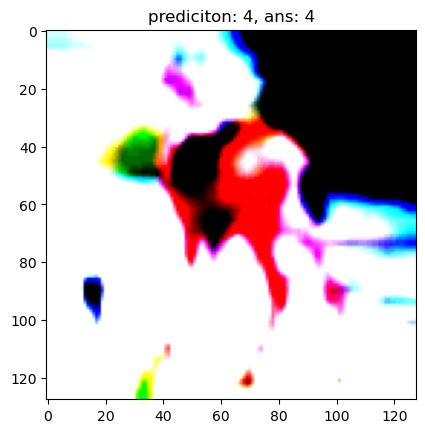

In [13]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [14]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

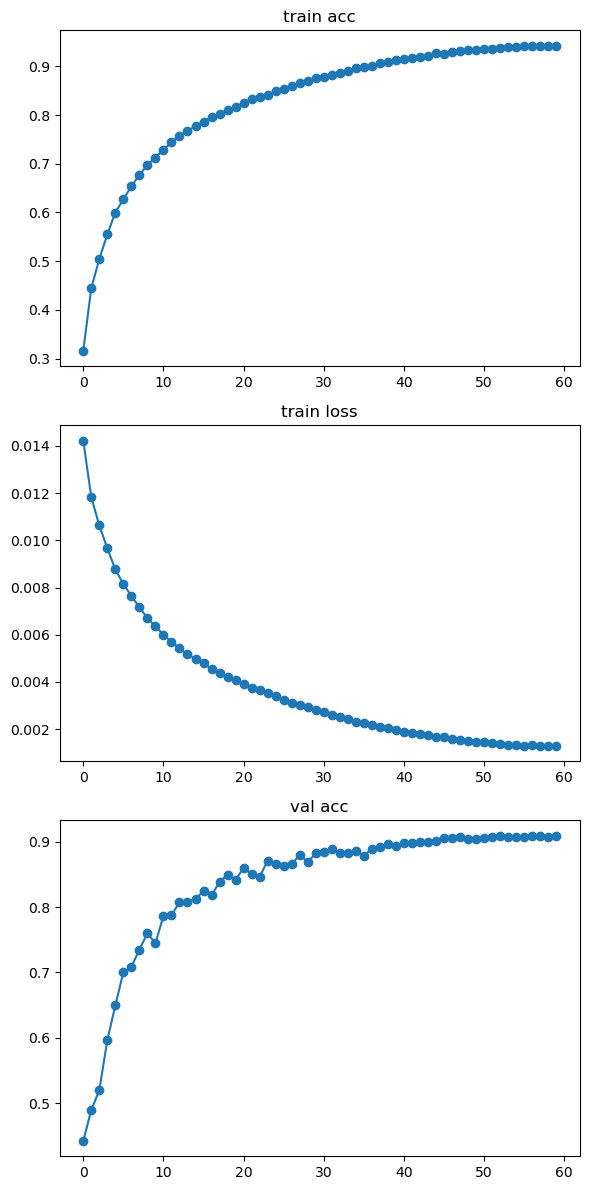

In [15]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()